In [25]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [26]:
from dotenv import load_dotenv
load_dotenv()

True

In [27]:
from langchain_groq import ChatGroq
import os
groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model="deepseek-r1-distill-llama-70b",api_key=groq_api_key)

In [28]:
import re
def clean_text(text):
    clean_text = re.sub(r"<think>.*?</think>\s*","",text,flags=re.DOTALL)
    return clean_text

In [29]:
response = llm.invoke("hello")
clean_text(response.content)

'Hello! How can I assist you today? 😊'

In [30]:
tavily_tool = TavilySearchResults()

In [31]:
code = """
x=5
y=x*2
print(y)
"""

In [32]:
repl = PythonREPL()
repl.run(code)

'10\n'

In [33]:
@tool
def python_repl_tool(code: Annotated[str,"The python code to execute to generate your chart."]):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Error: {e}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
<>:10: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Parth\AppData\Local\Temp\ipykernel_6356\835468712.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\Parth\AppData\Local\Temp\ipykernel_6356\835468712.py:10: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [34]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x=5
y=x*2
print(y)

\`\`\`
Stdout: 10



In [35]:
members=["researcher","coder"]
options=members+["FINISH"]
options

['researcher', 'coder', 'FINISH']

In [36]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["researcher","coder","FINISH"]

In [37]:
class State(MessagesState):
    next:str

In [38]:
system_prompt=f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status.
Each worker is designed for doing a specific task,so call worker for their specialized task. 
When finished, respond with FINISH.
"""

In [39]:
state={"next":["hi"]}

In [40]:
state["next"]

['hi']

In [41]:
[{"role":"system","content":system_prompt}] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status.\nEach worker is designed for doing a specific task,so call worker for their specialized task. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [42]:
def supervisor_node(state:State) -> Command[Literal["researcher","coder","__end__"]]:
    messages = [{"role":"system","content":system_prompt}]+ state["messages"]

    response = llm.with_structured_output(Router).invoke(messages)

    goto = response["next"]

    print("below my goto**********************************")

    print(goto)

    if goto == "FINISH":
        goto=END
    return Command(goto=goto,update={"next":goto})

In [43]:
def research_node(state: State) -> Command[Literal["supervisor"]]:
    research_agent = create_react_agent(llm,tools=[tavily_tool],prompt="You are a researcher. DO NOT do any math.")
    result = research_agent.invoke(state)

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto = "supervisor",
    )

In [44]:
def code_node(state: State) -> Command[Literal["supervisor"]]:
    
    code_agent = create_react_agent(llm, tools=[python_repl_tool])
    
    result = code_agent.invoke(state)
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [45]:
graph = StateGraph(State)

graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)

graph.add_edge(START,"supervisor")

app=graph.compile()

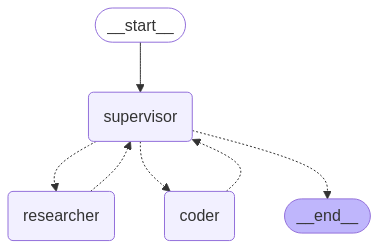

In [46]:
from IPython.display import display,Image

display(Image(app.get_graph().draw_mermaid_png()))

In [47]:
# app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
researcher
below my goto**********************************
coder
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
FINISH
((),
 {'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='0148a4dc-b9a8-4e88-a833-b8cfc5f7d534'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='6ca2b517-8aa8-4fbe-b090-06db841a0633'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='coder', id='aab929b1-70a6-4f39-9921-40cb1389e6b3'),
   HumanMessage(content='The square root of 42 is approximately 6.48.', additional_kwargs={}, response_metadata={}, name='researcher', id='b2ae425e-d463-42fc-b478-e1cf34f0e3c3'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='ff169091-69c0-49d8-a558-ed12999bd6f4'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='8852e20b-5731-420a-a9bf-ef761b6539f0'),
   HumanMessage(content='The square root of 42 is approximately 6.4807.', additional_kwargs={}, response_metadata={}, name='researcher', id='78215c01-36c7-4020-b773-74fa55b16838')],
  'next': '__end__'})

In [49]:
app.invoke({"messages": [("user", "generate python code to print 1 to 5")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
FINISH


((),
 {'messages': [HumanMessage(content='generate python code to print 1 to 5', additional_kwargs={}, response_metadata={}, id='2d073f1e-c125-402e-8314-acb264d37e0f'),
   HumanMessage(content='The Python code to print numbers from 1 to 5 is as follows:\n\n```python\nfor i in range(1, 6):\n    print(i)\n```\n\nThis will output:\n```\n1\n2\n3\n4\n5\n```', additional_kwargs={}, response_metadata={}, name='coder', id='465260dc-a05b-4313-9791-b46f17e5b6d5'),
   HumanMessage(content="Here's the Python code to print numbers from 1 to 5:\n\n```python\nfor i in range(1, 6):\n    print(i)\n```\n\nWhen executed, this will output:\n\n```\n1\n2\n3\n4\n5\n```\n\nLet me know if you need further assistance!", additional_kwargs={}, response_metadata={}, name='coder', id='c6b6147d-0502-46d4-81df-170bde2aa201'),
   HumanMessage(content="To print the numbers from 1 to 5 in Python, you can use a simple `for` loop with the `range()` function. Here's how you can do it:\n\n```python\nfor i in range(1, 6):\n 